In [47]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

from datasets import load_from_disk
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.001
batch_size = 512
latent_dim = 128          
condition_dim = 10        
gan_epochs = 150            
generation_size = 1000

full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']


train_x_full = np.array(train_dataset['embedding'])
train_y_full = np.array(train_dataset['labels'])


In [49]:

class DNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(DNNClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.fc(x)


class Generator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, output_dim=512):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        input_dim = latent_dim + condition_dim
        layers = []
        layers.append(nn.Linear(input_dim, start_dim))
        layers.append(nn.ReLU(inplace=True))
        current_dim = start_dim
        for i in range(1, n_layer):
            next_dim = current_dim * 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.BatchNorm1d(next_dim, momentum=0.8))
            layers.append(nn.ReLU(inplace=True))
            current_dim = next_dim
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)
    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, input_dim=512):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        input_dim = input_dim + condition_dim
        hidden_dim = start_dim * (2 ** (n_layer - 1))
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        current_dim = hidden_dim
        for i in range(1, n_layer):
            next_dim = current_dim // 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            current_dim = next_dim
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
    def forward(self, x, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([x, label_embedding], dim=1)
        return self.model(x)


def train_and_evaluate_dnn(model, train_loader, test_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_y.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")
    # Evaluate
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    test_acc = accuracy_score(all_labels, all_preds)
    return test_acc, all_preds, all_labels

class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.embeddings = hf_dataset["embedding"]
        self.labels = hf_dataset["labels"]
    def __len__(self):
        return len(self.embeddings)
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = self.labels[idx]
        return emb, label

train_ds = EmbeddingDataset(train_dataset)
test_ds = EmbeddingDataset(test_dataset)

def get_loader(dataset, batch_size=32, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)  


[Real Data Only] Training size: 20
Training DNN on real data...
Epoch 1: Train Loss=1.1799, Train Acc=0.2000
Epoch 2: Train Loss=0.6302, Train Acc=0.8500
Epoch 3: Train Loss=0.4520, Train Acc=0.9000
Epoch 4: Train Loss=0.3685, Train Acc=0.9000
Epoch 5: Train Loss=0.2514, Train Acc=0.9500
Epoch 6: Train Loss=0.1963, Train Acc=0.9500
Epoch 7: Train Loss=0.1725, Train Acc=0.9500
Epoch 8: Train Loss=0.1280, Train Acc=0.9500
Epoch 9: Train Loss=0.1233, Train Acc=1.0000
Epoch 10: Train Loss=0.1033, Train Acc=1.0000
DNN Test Accuracy (Real Data) for sample size 20: 0.7998
[GAN Epoch 1/150] D loss: 0.6943, G loss: 0.6732


/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/3598883103.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 2/150] D loss: 0.6401, G loss: 0.6762
[GAN Epoch 3/150] D loss: 0.5923, G loss: 0.6804
[GAN Epoch 4/150] D loss: 0.5437, G loss: 0.6831
[GAN Epoch 5/150] D loss: 0.4953, G loss: 0.6868
[GAN Epoch 6/150] D loss: 0.4530, G loss: 0.6875
[GAN Epoch 7/150] D loss: 0.4226, G loss: 0.6845
[GAN Epoch 8/150] D loss: 0.3968, G loss: 0.6970
[GAN Epoch 9/150] D loss: 0.3742, G loss: 0.7268
[GAN Epoch 10/150] D loss: 0.3505, G loss: 0.7781
[GAN Epoch 11/150] D loss: 0.3318, G loss: 0.8412
[GAN Epoch 12/150] D loss: 0.3173, G loss: 0.9018
[GAN Epoch 13/150] D loss: 0.3149, G loss: 0.9163
[GAN Epoch 14/150] D loss: 0.3228, G loss: 0.9109
[GAN Epoch 15/150] D loss: 0.3369, G loss: 0.9190
[GAN Epoch 16/150] D loss: 0.3529, G loss: 0.8681
[GAN Epoch 17/150] D loss: 0.3476, G loss: 0.9241
[GAN Epoch 18/150] D loss: 0.3323, G loss: 0.8699
[GAN Epoch 19/150] D loss: 0.2956, G loss: 1.1981
[GAN Epoch 20/150] D loss: 0.3582, G loss: 0.7209
[GAN Epoch 21/150] D loss: 0.2250, G loss: 1.2385
[GAN Epo

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/3598883103.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 17/150] D loss: 0.3606, G loss: 0.8777
[GAN Epoch 18/150] D loss: 0.3190, G loss: 0.9352
[GAN Epoch 19/150] D loss: 0.2578, G loss: 1.2033
[GAN Epoch 20/150] D loss: 0.2357, G loss: 1.0863
[GAN Epoch 21/150] D loss: 0.1917, G loss: 1.4783
[GAN Epoch 22/150] D loss: 0.2112, G loss: 1.1868
[GAN Epoch 23/150] D loss: 0.1907, G loss: 1.4326
[GAN Epoch 24/150] D loss: 0.2033, G loss: 1.3024
[GAN Epoch 25/150] D loss: 0.1893, G loss: 1.4590
[GAN Epoch 26/150] D loss: 0.1841, G loss: 1.3982
[GAN Epoch 27/150] D loss: 0.1576, G loss: 1.8003
[GAN Epoch 28/150] D loss: 0.1690, G loss: 1.4571
[GAN Epoch 29/150] D loss: 0.1189, G loss: 2.2774
[GAN Epoch 30/150] D loss: 0.1608, G loss: 1.4711
[GAN Epoch 31/150] D loss: 0.0933, G loss: 2.4516
[GAN Epoch 32/150] D loss: 0.1233, G loss: 1.7815
[GAN Epoch 33/150] D loss: 0.1301, G loss: 2.1081
[GAN Epoch 34/150] D loss: 0.1459, G loss: 1.6478
[GAN Epoch 35/150] D loss: 0.1531, G loss: 3.1013
[GAN Epoch 36/150] D loss: 0.7018, G loss: 0.3560


/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/3598883103.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 4/150] D loss: 0.5157, G loss: 0.6974
[GAN Epoch 5/150] D loss: 0.4685, G loss: 0.6950
[GAN Epoch 6/150] D loss: 0.4322, G loss: 0.6910
[GAN Epoch 7/150] D loss: 0.4041, G loss: 0.6963
[GAN Epoch 8/150] D loss: 0.3801, G loss: 0.7173
[GAN Epoch 9/150] D loss: 0.3525, G loss: 0.7677
[GAN Epoch 10/150] D loss: 0.3224, G loss: 0.8465
[GAN Epoch 11/150] D loss: 0.2999, G loss: 0.9278
[GAN Epoch 12/150] D loss: 0.2867, G loss: 0.9973
[GAN Epoch 13/150] D loss: 0.2976, G loss: 0.9751
[GAN Epoch 14/150] D loss: 0.3313, G loss: 0.9051
[GAN Epoch 15/150] D loss: 0.3824, G loss: 0.8252
[GAN Epoch 16/150] D loss: 0.4206, G loss: 0.7311
[GAN Epoch 17/150] D loss: 0.4150, G loss: 0.7893
[GAN Epoch 18/150] D loss: 0.3755, G loss: 0.7759
[GAN Epoch 19/150] D loss: 0.3109, G loss: 1.1083
[GAN Epoch 20/150] D loss: 0.2908, G loss: 0.9091
[GAN Epoch 21/150] D loss: 0.2100, G loss: 1.3119
[GAN Epoch 22/150] D loss: 0.1987, G loss: 1.3802
[GAN Epoch 23/150] D loss: 0.2119, G loss: 1.2247
[GAN E

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/3598883103.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


DNN Test Accuracy (Real Data) for sample size 100: 0.8857
[GAN Epoch 1/150] D loss: 0.6917, G loss: 0.6911
[GAN Epoch 2/150] D loss: 0.6280, G loss: 0.6918
[GAN Epoch 3/150] D loss: 0.5712, G loss: 0.6962
[GAN Epoch 4/150] D loss: 0.5173, G loss: 0.7017
[GAN Epoch 5/150] D loss: 0.4673, G loss: 0.7079
[GAN Epoch 6/150] D loss: 0.4263, G loss: 0.7136
[GAN Epoch 7/150] D loss: 0.3949, G loss: 0.7242
[GAN Epoch 8/150] D loss: 0.3699, G loss: 0.7467
[GAN Epoch 9/150] D loss: 0.3462, G loss: 0.7892
[GAN Epoch 10/150] D loss: 0.3265, G loss: 0.8440
[GAN Epoch 11/150] D loss: 0.3143, G loss: 0.9053
[GAN Epoch 12/150] D loss: 0.3156, G loss: 0.9370
[GAN Epoch 13/150] D loss: 0.3295, G loss: 0.9115
[GAN Epoch 14/150] D loss: 0.3563, G loss: 0.8632
[GAN Epoch 15/150] D loss: 0.3725, G loss: 0.8672
[GAN Epoch 16/150] D loss: 0.3711, G loss: 0.8217
[GAN Epoch 17/150] D loss: 0.3388, G loss: 0.9935
[GAN Epoch 18/150] D loss: 0.3176, G loss: 0.8686
[GAN Epoch 19/150] D loss: 0.2741, G loss: 1.2570
[

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/3598883103.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 8/150] D loss: 0.3715, G loss: 0.7542
[GAN Epoch 9/150] D loss: 0.3388, G loss: 0.8210
[GAN Epoch 10/150] D loss: 0.3086, G loss: 0.9109
[GAN Epoch 11/150] D loss: 0.2867, G loss: 1.0011
[GAN Epoch 12/150] D loss: 0.2796, G loss: 1.0420
[GAN Epoch 13/150] D loss: 0.2902, G loss: 1.0145
[GAN Epoch 14/150] D loss: 0.3155, G loss: 0.9804
[GAN Epoch 15/150] D loss: 0.3444, G loss: 0.9162
[GAN Epoch 16/150] D loss: 0.3524, G loss: 0.8967
[GAN Epoch 17/150] D loss: 0.3173, G loss: 0.9910
[GAN Epoch 18/150] D loss: 0.2592, G loss: 1.1082
[GAN Epoch 19/150] D loss: 0.2046, G loss: 1.3792
[GAN Epoch 20/150] D loss: 0.1782, G loss: 1.3441
[GAN Epoch 21/150] D loss: 0.1554, G loss: 1.6253
[GAN Epoch 22/150] D loss: 0.1674, G loss: 1.4318
[GAN Epoch 23/150] D loss: 0.1655, G loss: 1.5870
[GAN Epoch 24/150] D loss: 0.1823, G loss: 1.3679
[GAN Epoch 25/150] D loss: 0.1705, G loss: 1.7165
[GAN Epoch 26/150] D loss: 0.2131, G loss: 1.1937
[GAN Epoch 27/150] D loss: 0.1340, G loss: 2.0985
[G

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/3598883103.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/150] D loss: 0.6558, G loss: 0.6947
[GAN Epoch 2/150] D loss: 0.5436, G loss: 0.6983
[GAN Epoch 3/150] D loss: 0.4541, G loss: 0.6960
[GAN Epoch 4/150] D loss: 0.4021, G loss: 0.6960
[GAN Epoch 5/150] D loss: 0.3581, G loss: 0.7732
[GAN Epoch 6/150] D loss: 0.3228, G loss: 0.9113
[GAN Epoch 7/150] D loss: 0.3360, G loss: 0.8974
[GAN Epoch 8/150] D loss: 0.3752, G loss: 0.8328
[GAN Epoch 9/150] D loss: 0.3638, G loss: 0.8477
[GAN Epoch 10/150] D loss: 0.3006, G loss: 1.0094
[GAN Epoch 11/150] D loss: 0.2363, G loss: 1.1898
[GAN Epoch 12/150] D loss: 0.2165, G loss: 1.2302
[GAN Epoch 13/150] D loss: 0.2064, G loss: 1.3387
[GAN Epoch 14/150] D loss: 0.1878, G loss: 1.4991
[GAN Epoch 15/150] D loss: 0.1729, G loss: 1.7335
[GAN Epoch 16/150] D loss: 0.2374, G loss: 1.7641
[GAN Epoch 17/150] D loss: 0.1610, G loss: 1.5744
[GAN Epoch 18/150] D loss: 0.2137, G loss: 1.5384
[GAN Epoch 19/150] D loss: 0.3700, G loss: 1.9617
[GAN Epoch 20/150] D loss: 0.0420, G loss: 3.2604
[GAN Epoc

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 1: Train Loss=0.3772, Train Acc=0.8697
Epoch 2: Train Loss=0.2713, Train Acc=0.9061
Epoch 3: Train Loss=0.2402, Train Acc=0.9131
Epoch 4: Train Loss=0.2375, Train Acc=0.9130
Epoch 5: Train Loss=0.2315, Train Acc=0.9153
Epoch 6: Train Loss=0.2307, Train Acc=0.9163
Epoch 7: Train Loss=0.2283, Train Acc=0.9160
Epoch 8: Train Loss=0.2204, Train Acc=0.9174
Epoch 9: Train Loss=0.2219, Train Acc=0.9178
Epoch 10: Train Loss=0.2216, Train Acc=0.9190
DNN Test Accuracy (Real Data) for sample size 7872: 0.9126
[GAN Epoch 1/150] D loss: 0.4463, G loss: 0.7372


/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/3598883103.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 2/150] D loss: 0.2802, G loss: 1.1918
[GAN Epoch 3/150] D loss: 0.1580, G loss: 2.1290
[GAN Epoch 4/150] D loss: 0.0692, G loss: 2.7417
[GAN Epoch 5/150] D loss: 0.3929, G loss: 3.2845
[GAN Epoch 6/150] D loss: 0.2914, G loss: 1.6665
[GAN Epoch 7/150] D loss: 0.2330, G loss: 2.4159
[GAN Epoch 8/150] D loss: 0.2661, G loss: 2.5799
[GAN Epoch 9/150] D loss: 0.2796, G loss: 2.6299
[GAN Epoch 10/150] D loss: 0.2902, G loss: 2.3489
[GAN Epoch 11/150] D loss: 0.3097, G loss: 2.3648
[GAN Epoch 12/150] D loss: 0.3707, G loss: 2.4565
[GAN Epoch 13/150] D loss: 0.3505, G loss: 2.1617
[GAN Epoch 14/150] D loss: 0.3820, G loss: 2.1035
[GAN Epoch 15/150] D loss: 0.3781, G loss: 1.9140
[GAN Epoch 16/150] D loss: 0.4129, G loss: 1.6732
[GAN Epoch 17/150] D loss: 0.4624, G loss: 1.8350
[GAN Epoch 18/150] D loss: 0.4460, G loss: 1.7501
[GAN Epoch 19/150] D loss: 0.4399, G loss: 1.7790
[GAN Epoch 20/150] D loss: 0.4116, G loss: 1.7938
[GAN Epoch 21/150] D loss: 0.4532, G loss: 1.7824
[GAN Epo

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


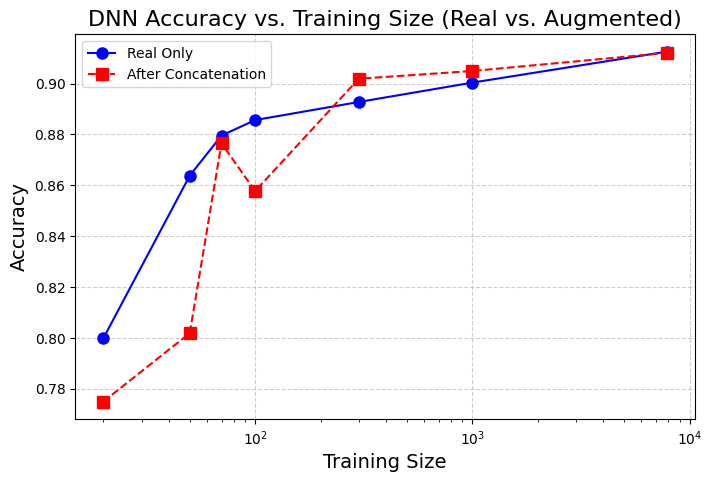

In [50]:
sample_sizes = [20, 50, 70, 100, 300, 1000, len(train_ds)]
dnn_accuracy_before = {}
dnn_accuracy_after = {}

for size in sample_sizes:
    print(f"\n[Real Data Only] Training size: {size}")
    train_subset = torch.utils.data.Subset(train_ds, range(size))
    train_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = get_loader(test_ds, batch_size=batch_size, shuffle=False)

    input_dim = train_ds[0][0].shape[0]  
    hidden_dim = 128
    num_classes = len(np.unique(train_y_full)) if 'train_y_full' in globals() else 3
    dnn_model = DNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    dnn_model.to(device)
    
    print("Training DNN on real data...")
    acc_before, preds_before, labels_before = train_and_evaluate_dnn(dnn_model, train_loader, test_loader, num_epochs, learning_rate, device)
    print(f"DNN Test Accuracy (Real Data) for sample size {size}: {acc_before:.4f}")
    dnn_accuracy_before[size] = acc_before
    

    generator = Generator(
        latent_dim=latent_dim,
        condition_dim=condition_dim,
        num_classes=num_classes,
        start_dim=latent_dim * 2,
        n_layer=3,
        output_dim=input_dim  
    )
    discriminator = Discriminator(
        condition_dim=condition_dim,
        num_classes=num_classes,
        start_dim=256,
        n_layer=3,
        input_dim=input_dim
    )
    generator.to(device)
    discriminator.to(device)
    adversarial_loss = nn.BCELoss().to(device)


    optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    gan_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    for epoch in range(gan_epochs):
        d_loss_epoch, g_loss_epoch = 0.0, 0.0
        for embeddings, labels in gan_loader:
            embeddings = embeddings.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            b_size = embeddings.size(0)
            valid = torch.ones(b_size, 1, device=device)
            fake = torch.zeros(b_size, 1, device=device)
            # -----------------
            # Train Generator
            # -----------------
            optimizer_G.zero_grad()
            z = torch.randn(b_size, latent_dim, device=device)
            gen_data = generator(z, labels)
            g_loss = adversarial_loss(discriminator(gen_data, labels), valid)
            g_loss.backward()
            optimizer_G.step()
            # -----------------
            # Train Discriminator
            # -----------------
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(embeddings, labels), valid)
            fake_loss = adversarial_loss(discriminator(gen_data.detach(), labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()
        print(f"[GAN Epoch {epoch+1}/{gan_epochs}] D loss: {d_loss_epoch/len(gan_loader):.4f}, G loss: {g_loss_epoch/len(gan_loader):.4f}")
    

    synthetic_data_list = []
    synthetic_labels_list = []
    unique_labels = np.unique(train_y_full) if 'train_y_full' in globals() else [0,1,2]
    for lab in unique_labels:
        lab_tensor = torch.full((generation_size,), lab, dtype=torch.long, device=device)
        z = torch.randn(generation_size, latent_dim, device=device)
        synth = generator(z, lab_tensor).cpu().detach().numpy()
        synthetic_data_list.append(synth)
        synthetic_labels_list.append(np.full((generation_size,), lab))
    synthetic_x = np.concatenate(synthetic_data_list, axis=0)
    synthetic_y = np.concatenate(synthetic_labels_list, axis=0)
    
    # -------------------------------
    # Concatenate original training data with synthetic data
    # -------------------------------
    X_train = train_x_full[:size]
    y_train = train_y_full[:size]
    train_combined_x = np.concatenate([X_train, synthetic_x], axis=0)
    train_combined_y = np.concatenate([y_train, synthetic_y], axis=0)
    
    train_combined_dataset = TensorDataset(torch.tensor(train_combined_x, dtype=torch.float),
                                             torch.tensor(train_combined_y, dtype=torch.long))
    train_combined_loader = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)

    dnn_model_aug = DNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    dnn_model_aug.to(device)
    
    print("Training DNN on real + synthetic (concatenated) data...")
    acc_after, preds_after, labels_after = train_and_evaluate_dnn(dnn_model_aug, train_combined_loader, test_loader, num_epochs, learning_rate, device)
    print(f"DNN Test Accuracy (After Concatenation) for sample size {size}: {acc_after:.4f}")
    dnn_accuracy_after[size] = acc_after

summary_df = pd.DataFrame(
    [[s, dnn_accuracy_before[s], dnn_accuracy_after[s]] for s in sample_sizes],
    columns=["Train Samples", "Real Only Accuracy", "After Concatenation Accuracy"]
)
print("Accuracy Summary:")
print(tabulate.tabulate(summary_df.values, headers=summary_df.columns, tablefmt="fancy_grid"))

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, list(dnn_accuracy_before.values()), marker='o', linestyle='-', color='b', markersize=8, label="Real Only")
plt.plot(sample_sizes, list(dnn_accuracy_after.values()), marker='s', linestyle='--', color='r', markersize=8, label="After Concatenation")
plt.xlabel("Training Size", fontsize=14, fontfamily="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontfamily="Times New Roman")
plt.title("DNN Accuracy vs. Training Size (Real vs. Augmented)", fontsize=16, fontfamily="Times New Roman")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()
